# New Mexico Elevation Gradient RS Data Curation
#### Dan Krofcheck, Marcy Litvak

The objective of this notebook is to collect and curate time series remote sensing data for the network of flux towers in the Litvak Lab across all available satellite missions using the Google Earthe Engine API. In doing so we aim to generate a collection of satellite time series that will provide ecological context, both spatial and temporal, for the local impacts of the recent significant droughts experienced throughout the region. For a description of the NMEG and the flux towers distributed across it, see http://www.litvaklab.org/publications.html.

Here we develop the framework to acquire and analyze the remote sensing portion of the analysis, which we will then use to address questions related to changes in ecosystem function for the region.


### Import required libraries
Earth Engine API requires a one time token generation via a username and password prompt. See https://developers.google.com/earth-engine/command_line#authenticate for more information.

The general workflow establishes a feature collection of geoJson geometries, converts those geomoetries to a pandas dataframe, and iterates over it to retrieve reflectance data for the region of interest. Timestamps are retrieved from the metadata for each image and appended to the dataframes for each element inside the feature collection.

In [1]:
%matplotlib inline

# Import Dependencies
import ee, datetime
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.dates as mdates
from IPython.display import Image
from matplotlib import dates
from pylab import *

from osgeo import ogr
import os

ee.Initialize()

### Image collections
We are going to collect remote sensing data from a range of satellite missions, including NASA products like the MODIS and Landsat constellations, as well as the ESA sponsored Sentinel constellations. While each sensor has different spatial and spectral capabilities, we will generate an asychronous collection of mean pixel values for each feature in the collection of geometries, on a per band basis. Each acquisition will have the sensing time associated with it, allowing us to look at the imagery in a time series fashion, on a band by band basis.

In [2]:
# Create image collection
L4 = ee.ImageCollection('LANDSAT/LT04/C01/T1_SR');
L5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR');
L7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR');
L8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR');
S2 = ee.ImageCollection("COPERNICUS/S2")

### The feature collection for the NMEG
Are stored in my google earth engine account, so I can retrieve the feature collection given my login. However, we could create our own geoJson object here, or generate a list of points or custom geometries as well. We could also have loaded in a shapefile directly using something like shapely.

This collection of geometries has FID and NAME attributes, each of which will propagate through to the finalized dataframe.

In [3]:
NMEG_Sites = ee.FeatureCollection("users/krofcheck/NMEG_sites");

#### This isn't the best way to handle this process
but its gets us what we need rather quickly. https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt

This is untennable in the long term given the compuational costs associated with it, and I'll have to sort out a more efficient way to handle it soon.

In [45]:
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        # attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    df['geometry'] = map(lambda s: shape(s), df.geometry)    
    return df

# ==========================================================================
# Function to iterate over image collection, returning a pandas dataframe
def extract_point_values(img_id, pts):
    image = ee.Image(img_id)

    fc_image_red = image.reduceRegions(collection=pts,
                                  reducer=ee.Reducer.mean(),
                                  scale=90, bestEffort = True)

    # Convert to Pandas Dataframe
    df_image_red = fc2df(fc_image_red)

    # Add Date as Variable
    df_image_red['date'] = image.getInfo()['properties']['SENSING_TIME']

    return df_image_red

### I need to learn a good bit more about efficient practices
for this sort of process. I routinely get 'user limit exceeded' errors etc -- in order to get around that for the time being, I'm breaking up the requests into 5 year chunks for the sensors that need it, and I reduced the scale factor of the reduceRegions function mapping by an order of three. I'll revisit this soon.

In [5]:
#### Load Raster
l8 = L8.filterBounds(NMEG_Sites)

#### Make list of image IDs
l8_id = []
for f in l8.getInfo()['features']:
    image_id = f['properties']['system:index']
    image_id = 'LANDSAT/LC08/C01/T1_SR/' + image_id
    l8_id.append(image_id)

#### Create Initial Pandas Dataframe
ls8_all = extract_point_values(l8_id[0], NMEG_Sites)
ls8_all = ls8_all.drop([0,1])

#### Iterate over all impages
for scene in l8_id:
    ls8_all = ls8_all.append(extract_point_values(scene, NMEG_Sites))

#### Format the timstamp information into a POSIX like type
#### and make use of the pandas datetime object to retrieve year, month, and doy
TS = pd.to_datetime(ls8_all.date.values)
ls8_all.index = TS
ls8_all['YEAR'] = TS.year
ls8_all['MONTH'] = TS.month
ls8_all['DOY'] = TS.dayofyear

#### For completeness, append the sensor and level
ls8_all['SENSOR'] = 'LS8'
ls8_all['OBS'] = 'SR'

### Here we repeat the process for Landsat 7 and then again for Landsat 5. 
I need to split up these requests given that they are prone to fail, and the total acquisition time for all three sensors at this point is around 7 hours. Again, that time should be significantly reduced when I optimize the requests through earth engine's API.

In [47]:
#### Load Raster
#l70 = L7.filterDate('2000-01-01', '2004-12-31').filterBounds(NMEG_Sites)
#l71 = L7.filterDate('2005-01-01', '2008-12-31').filterBounds(NMEG_Sites)
#l72 = L7.filterDate('2011-06-09', '2012-12-31').filterBounds(NMEG_Sites)
l73 = L7.filterDate('2013-01-01', '2016-12-31').filterBounds(NMEG_Sites)
l74 = L7.filterDate('2017-01-01', '2018-9-1').filterBounds(NMEG_Sites)
idx = 3
for l7 in [l73,l74]:
    print(idx)
    #### Make list of image IDs
    l7_id = []
    for f in l7.getInfo()['features']:
        l7_image_id = f['properties']['system:index']
        l7_image_id = 'LANDSAT/LE07/C01/T1_SR/' + l7_image_id
        l7_id.append(l7_image_id)

    #### Create Initial Pandas Dataframe
    if idx == 0:
        ls7_all = extract_point_values(l7_id[0], NMEG_Sites)
        ls7_all = ls7_all.drop([0,1])

    #### Iterate over all impages
    for scene in l7_id:
        ls7_all = ls7_all.append(extract_point_values(scene, NMEG_Sites))
    idx += 1

#### Format the timstamp information into a POSIX like type
#### and make use of the pandas datetime object to retrieve year, month, and doy
TS = pd.to_datetime(ls7_all.date.values)
ls7_all.index = TS
ls7_all['YEAR'] = TS.year
ls7_all['MONTH'] = TS.month
ls7_all['DOY'] = TS.dayofyear

#### For completeness, append the sensor and level
ls7_all['SENSOR'] = 'LS7'
ls7_all['OBS'] = 'SR'

3
4


In [52]:
#### Load Raster
#l50 = L5.filterDate('1984-01-01', '1988-12-31').filterBounds(NMEG_Sites)
#l51 = L5.filterDate('1989-01-01', '1992-12-31').filterBounds(NMEG_Sites)
#l52 = L5.filterDate('1993-01-01', '1996-12-31').filterBounds(NMEG_Sites)
#l53 = L5.filterDate('1997-01-01', '2001-12-31').filterBounds(NMEG_Sites)
#l54 = L5.filterDate('2002-01-01', '2005-12-31').filterBounds(NMEG_Sites)
l55 = L5.filterDate('2006-08-20', '2010-12-31').filterBounds(NMEG_Sites)
l56 = L5.filterDate('2011-01-01', '2013-12-31').filterBounds(NMEG_Sites)
#idx = 0
for l5 in [l55, l56]:
    print(idx)
    #### Make list of image IDs
    l5_id = []
    for f in l5.getInfo()['features']:
        l5_image_id = f['properties']['system:index']
        l5_image_id = 'LANDSAT/LT05/C01/T1_SR/' + l5_image_id
        l5_id.append(l5_image_id)

    #### Create Initial Pandas Dataframe
    if idx == 0:
        ls5_all = extract_point_values(l5_id[0], NMEG_Sites)
        ls5_all = ls5_all.drop([0,1])

    #### Iterate over all impages
    for scene in l5_id:
        ls5_all = ls5_all.append(extract_point_values(scene, NMEG_Sites))
    idx += 1

#### Format the timstamp information into a POSIX like type
#### and make use of the pandas datetime object to retrieve year, month, and doy
TS = pd.to_datetime(ls5_all.date.values)
ls5_all.index = TS
ls5_all['YEAR'] = TS.year
ls5_all['MONTH'] = TS.month
ls5_all['DOY'] = TS.dayofyear

#### For completeness, append the sensor and level
ls5_all['SENSOR'] = 'LS5'
ls5_all['OBS'] = 'SR'

5
6


### Now we can calculate a quick band index for each sensor
and concatentate them together in one large dataframe

In [98]:
### Concatenate the LS sensors
ls8_all['NDVI'] = (ls8_all.B5 - ls8_all.B4) / (ls8_all.B5 + ls8_all.B4)
ls7_all['NDVI'] = (ls7_all.B4 - ls7_all.B3) / (ls7_all.B4 + ls7_all.B3)
ls5_all['NDVI'] = (ls5_all.B4 - ls5_all.B3) / (ls5_all.B4 + ls5_all.B3)
allLS = pd.concat([ls8_all.dropna(), ls7_all.dropna(), ls5_all.dropna()], sort = True)

### Write the output to a CSV
to avoid having to re-request the data through earth engine

In [103]:
allLS.to_csv('allLS.csv')

### Filtering and data prep
We're going to end up doing quite a bit here, in terms of managing the interval of data to account for the apparent inconsistency in timestamp between acquisitions. Ultimately, this will allow us to calculate means etc on meaningful intervals, like month, rather than having to think in terms of the number of observations for window size -- which temporally, is variant in length.

In [ ]:
# We don't want to filter much, 
allLS.NDVI[allLS.NDVI < 0.01] = np.nan
allLS.NDVI[allLS.NDVI > 1] = np.nan

### Quickly setup some plot characteristics
based on site. This can get moved to a plot params file or something, but for now we'll leave it in.

In [129]:
allLS.Name.unique()
siteNames = ['VCS','VCM','VCP','MPJ','WJS','SES','SEG']
gcolour=[0.9,0.5, 0.0];
ngcolour=[0.9, 0.6, 0.0];
scolour=[0.6, 0.2, 0];
jcolour=[0.25, 1.0, 0.0];
pjcolour=[0.0, 0.5, 0.0];
pjgcolour=[0.2, 0.5, 0.0];
pcolour=[0.5, 0.5, 1.0];
mcolour=[0.0, 0.0, 0.6];
vcscolor = '#BA55D3'
siteColors = [vcscolor, mcolour, pcolour, pjcolour, jcolour, scolour, gcolour]

### Quickly gin up some time series
to illustrate the breadth of the dataset. Just plotting NDVI is simple enough, and we can color code the plots by the site colors above. One thing worth noting here is that as with most greenness indices that are affected by things like clouds and snow, we should show some sort of quantile estimate of the highest values over a windowed period. Unfortunately, we don't have our timestamps setup yet to accomodate that -- so we will look at a static number of observations for our window size.

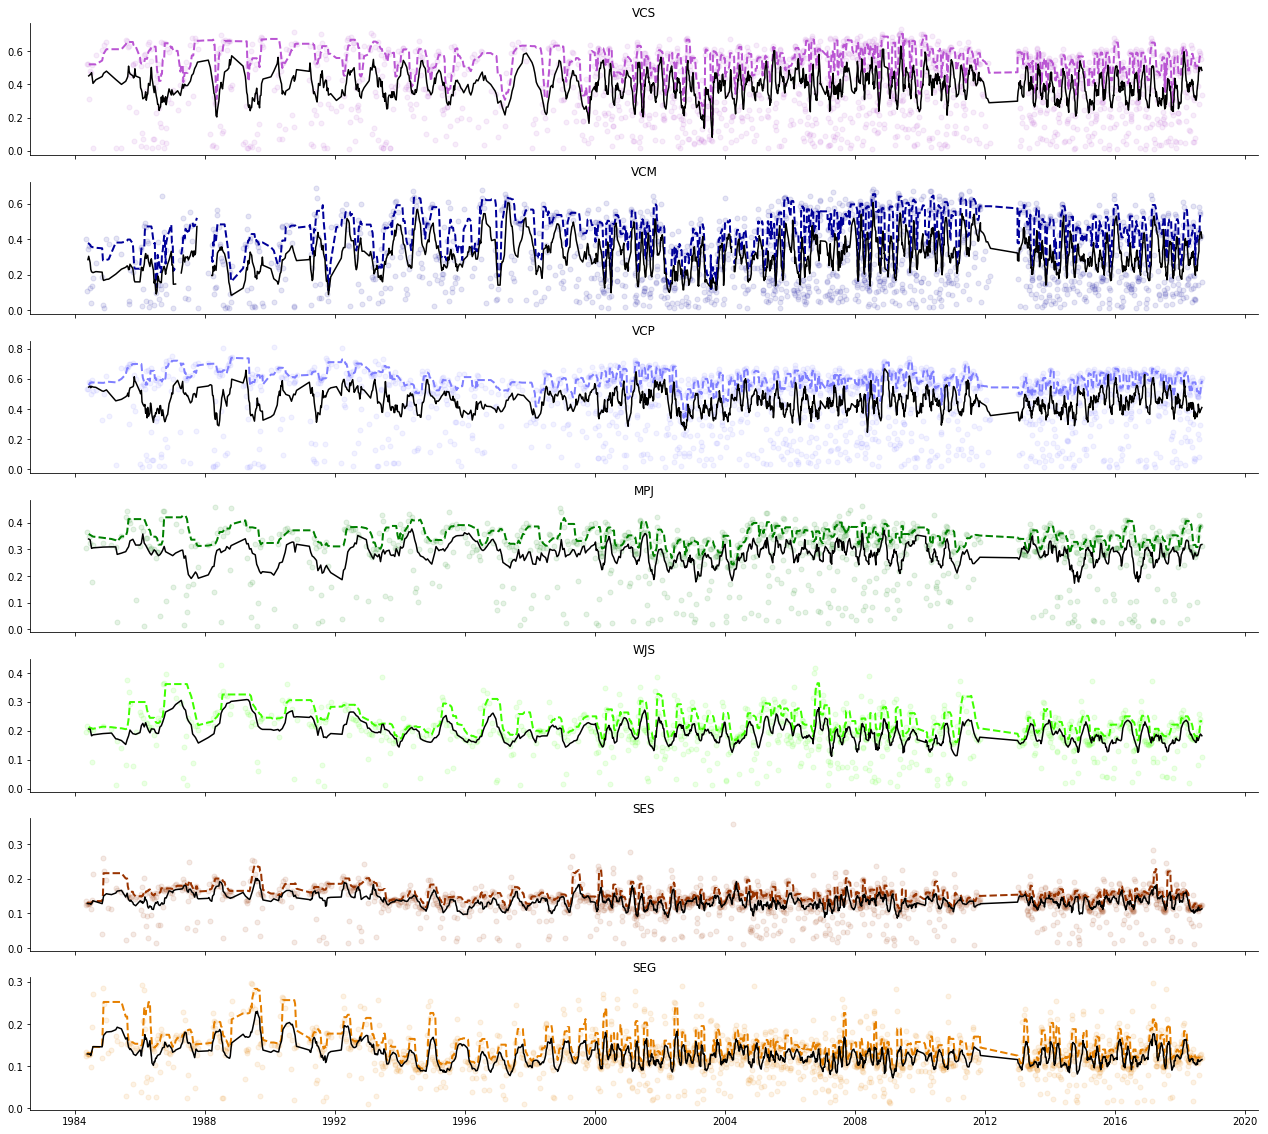

In [139]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize = (22,20), sharex = True)
axs = f.axes
idx = 0

for site in siteNames:
    ax = axs[idx]
    siteDF = allLS[allLS.Name == site]
    ax.plot(siteDF.index.sort_values(), 
            siteDF.NDVI.rolling(10, min_periods=3).quantile(.80), 
            ls = '--', lw = 2, color = siteColors[idx])
    ax.plot(siteDF.index.sort_values(), 
            siteDF.NDVI, ls = '', 
            marker = '.', markersize = 10, alpha = 0.1, color = siteColors[idx])

    ax.plot(siteDF.index.sort_values(), 
            siteDF.NDVI.rolling(10, min_periods=3).mean(), ls = '-', color = 'black')

    ax.set_title(site)
    #ax.set_ylim([0,1])
    idx += 1
    
sns.despine()
plt.savefig('allSitesRS_lr_pts.tif', dpi = 100)
plt.savefig('allSitesRS_hr_pts.tif', dpi = 150)